In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the combined dataset
# Adjust path based on where you're running this notebook from
df = pd.read_csv('../Retrieval/Data_Combined/dota_pro_combined.csv')
# If running from project root, use: 'Retrieval/Data_Combined/dota_pro_combined.csv'
# If you copied CSV to Analysis folder, use: 'dota_pro_combined.csv'

print("Data loaded successfully!")
print(f"Shape: {df.shape}\n")

print("-"*80)
print("DATASET DESCRIPTION FOR PROGRESS REPORT")
print("-"*80)

Data loaded successfully!
Shape: (15000, 65)

--------------------------------------------------------------------------------
DATASET DESCRIPTION FOR PROGRESS REPORT
--------------------------------------------------------------------------------


In [2]:
# 1. BASIC DATASET CHARACTERISTICS
print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"Total matches collected: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"Total float values: {df.select_dtypes(include=['float64', 'float32']).size:,}")
print(f"Dataset shape: {df.shape}")
print(f"\nData collection method: OpenDota API (/proMatches endpoint)")
print(f"Match type: Professional matches only")
print(f"Time period: Recent professional matches (2024-2025)")


1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Total matches collected: 15,000
Total features: 65
Total float values: 750,000
Dataset shape: (15000, 65)

Data collection method: OpenDota API (/proMatches endpoint)
Match type: Professional matches only
Time period: Recent professional matches (2024-2025)


In [4]:
# 2. FEATURE CATEGORIES
print("\n\n2. FEATURE CATEGORIES")
print("-" * 80)

# Categorize features
match_features = ['match_id', 'match_seq_num', 'patch', 'region', 'start_time', 
                  'duration', 'game_mode', 'skill', 'first_blood_time']
team_stats = [col for col in df.columns if any(x in col for x in ['_radiant', '_dire'])]
objective_features = [col for col in df.columns if 'objective' in col]
event_features = [col for col in df.columns if 'event' in col]
ward_features = [col for col in df.columns if 'ward' in col]
advantage_features = [col for col in df.columns if 'advantage' in col]

print(f"Match metadata: {len(match_features)} features")
print(f"  Examples: {match_features[:5]}")
print(f"\nTeam statistics: {len(team_stats)} features")
print(f"  Examples: {team_stats[:5]}")
print(f"\nObjective tracking: {len(objective_features)} features")
print(f"  Examples: {objective_features[:3]}")
print(f"\nIn-game events: {len(event_features)} features")
print(f"  Examples: {event_features}")
print(f"\nVision control: {len(ward_features)} features")
print(f"  Examples: {ward_features}")
print(f"\nAdvantage metrics: {len(advantage_features)} features")
print(f"  Examples: {advantage_features}")



2. FEATURE CATEGORIES
--------------------------------------------------------------------------------
Match metadata: 9 features
  Examples: ['match_id', 'match_seq_num', 'patch', 'region', 'start_time']

Team statistics: 36 features
  Examples: ['barracks_status_dire', 'barracks_status_radiant', 'tower_status_dire', 'tower_status_radiant', 'kills_dire']

Objective tracking: 8 features
  Examples: ['objective_type_CHAT_MESSAGE_AEGIS', 'objective_type_CHAT_MESSAGE_AEGIS_STOLEN', 'objective_type_CHAT_MESSAGE_COURIER_LOST']

In-game events: 4 features
  Examples: ['event_buyback_count', 'event_kill_count', 'event_purchase_count', 'event_rune_count']

Vision control: 2 features
  Examples: ['observer_wards_placed', 'sentry_wards_placed']

Advantage metrics: 2 features
  Examples: ['final_gold_advantage', 'final_xp_advantage']


In [5]:
# 3. MISSING DATA ANALYSIS
print("\n\n3. MISSING DATA ANALYSIS")
print("-" * 80)
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)

print(f"Columns with missing data: {(missing_counts > 0).sum()}")
if (missing_counts > 0).sum() > 0:
    print("\nTop 10 columns with missing values:")
    print(missing_df[missing_df['Missing Count'] > 0].head(10))
    
    # Analyze patterns in missing data
    print("\nMissing data patterns:")
    for col in missing_df[missing_df['Missing Count'] > 0].head(5).index:
        print(f"  {col}: {missing_counts[col]} ({missing_pct[col]:.1f}%)")
        print(f"    - Likely reason: Feature not present in all match types/patches")




3. MISSING DATA ANALYSIS
--------------------------------------------------------------------------------
Columns with missing data: 18

Top 10 columns with missing values:
                                           Missing Count  Missing %
skill                                              15000     100.00
region                                               206       1.37
objective_type_CHAT_MESSAGE_AEGIS_STOLEN               6       0.04
objective_type_CHAT_MESSAGE_DENIED_AEGIS               6       0.04
objective_type_CHAT_MESSAGE_FIRSTBLOOD                 6       0.04
objective_type_CHAT_MESSAGE_MINIBOSS_KILL              6       0.04
objective_type_CHAT_MESSAGE_ROSHAN_KILL                6       0.04
objective_type_building_kill                           6       0.04
final_gold_advantage                                   6       0.04
final_xp_advantage                                     6       0.04

Missing data patterns:
  skill: 15000 (100.0%)
    - Likely reason: Feature 

In [6]:
# 4. TARGET VARIABLE DISTRIBUTION
print("\n\n4. TARGET VARIABLE: RADIANT_WIN")
print("-" * 80)
win_counts = df['radiant_win'].value_counts()
print(f"Radiant wins: {win_counts.get(True, 0)} ({win_counts.get(True, 0)/len(df)*100:.2f}%)")
print(f"Dire wins: {win_counts.get(False, 0)} ({win_counts.get(False, 0)/len(df)*100:.2f}%)")
print(f"Class balance: {'Well-balanced' if abs(0.5 - win_counts.get(True, 0)/len(df)) < 0.05 else 'Slight imbalance'}")




4. TARGET VARIABLE: RADIANT_WIN
--------------------------------------------------------------------------------
Radiant wins: 7767 (51.78%)
Dire wins: 7233 (48.22%)
Class balance: Well-balanced


In [7]:
# 5. KEY NUMERIC FEATURE DISTRIBUTIONS
print("\n\n5. KEY FEATURE DISTRIBUTIONS")
print("-" * 80)
numeric_features = ['duration', 'kills_radiant', 'kills_dire', 
                   'gold_per_min_radiant', 'gold_per_min_dire',
                   'final_gold_advantage', 'final_xp_advantage']

for feature in numeric_features:
    if feature in df.columns:
        data = df[feature].dropna()
        print(f"\n{feature}:")
        print(f"  Mean: {data.mean():.2f} | Median: {data.median():.2f}")
        print(f"  Std: {data.std():.2f} | Range: [{data.min():.2f}, {data.max():.2f}]")
        print(f"  Skewness: {stats.skew(data):.2f} | Kurtosis: {stats.kurtosis(data):.2f}")




5. KEY FEATURE DISTRIBUTIONS
--------------------------------------------------------------------------------

duration:
  Mean: 2013.23 | Median: 1891.00
  Std: 583.45 | Range: [401.00, 7148.00]
  Skewness: 1.19 | Kurtosis: 2.71

kills_radiant:
  Mean: 29.67 | Median: 30.00
  Std: 12.76 | Range: [0.00, 92.00]
  Skewness: 0.26 | Kurtosis: -0.07

kills_dire:
  Mean: 29.12 | Median: 29.00
  Std: 13.18 | Range: [0.00, 88.00]
  Skewness: 0.27 | Kurtosis: -0.18

gold_per_min_radiant:
  Mean: 2441.00 | Median: 2517.00
  Std: 379.34 | Range: [624.00, 3667.00]
  Skewness: -0.53 | Kurtosis: -0.17

gold_per_min_dire:
  Mean: 2420.50 | Median: 2490.00
  Std: 410.11 | Range: [648.00, 3568.00]
  Skewness: -0.52 | Kurtosis: -0.11

final_gold_advantage:
  Mean: 253.50 | Median: 2504.00
  Std: 17879.41 | Range: [-52994.00, 64401.00]
  Skewness: -0.06 | Kurtosis: -1.21

final_xp_advantage:
  Mean: 390.18 | Median: 4004.00
  Std: 28266.49 | Range: [-107600.00, 105737.00]
  Skewness: -0.07 | Kurtosis: 

In [8]:
# 6. CORRELATION ANALYSIS WITH TARGET
print("\n\n6. CORRELATION WITH TARGET (radiant_win)")
print("-" * 80)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numeric_cols].corrwith(df['radiant_win'].astype(int)).abs().sort_values(ascending=False)

print("Top 15 features most correlated with match outcome:")
for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
    if feature != 'radiant_win':
        print(f"{i:2d}. {feature:40s}: {corr:.4f}")



6. CORRELATION WITH TARGET (radiant_win)
--------------------------------------------------------------------------------
Top 15 features most correlated with match outcome:
 1. final_gold_advantage                    : 0.8929
 2. final_xp_advantage                      : 0.8605
 3. tower_damage_dire                       : 0.7658
 4. gold_per_min_dire                       : 0.7588
 5. tower_damage_radiant                    : 0.7551
 6. gold_per_min_radiant                    : 0.7472
 7. towers_killed_dire                      : 0.7349
 8. towers_killed_radiant                   : 0.7175
 9. xp_per_min_dire                         : 0.6461
10. kills_dire                              : 0.6203
11. barracks_status_radiant                 : 0.6187
12. dire_score                              : 0.6146
13. deaths_radiant                          : 0.6132
14. assists_dire                            : 0.6097
15. xp_per_min_radiant                      : 0.5988


In [9]:
# 7. OUTLIER DETECTION
print("\n\n7. OUTLIER DETECTION")
print("-" * 80)
for feature in ['duration', 'kills_radiant', 'kills_dire']:
    if feature in df.columns:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((df[feature] < Q1 - 1.5*IQR) | (df[feature] > Q3 + 1.5*IQR)).sum()
        print(f"{feature}: {outliers} outliers ({outliers/len(df)*100:.2f}%)")




7. OUTLIER DETECTION
--------------------------------------------------------------------------------
duration: 490 outliers (3.27%)
kills_radiant: 73 outliers (0.49%)
kills_dire: 64 outliers (0.43%)




8. GENERATING VISUALIZATIONS...
--------------------------------------------------------------------------------


C:\Users\ryan\AppData\Local\Temp\ipykernel_20360\3068911162.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_by_duration = df.groupby(duration_bins)['radiant_win'].mean()


Saved visualization to 'dataset_eda.png'


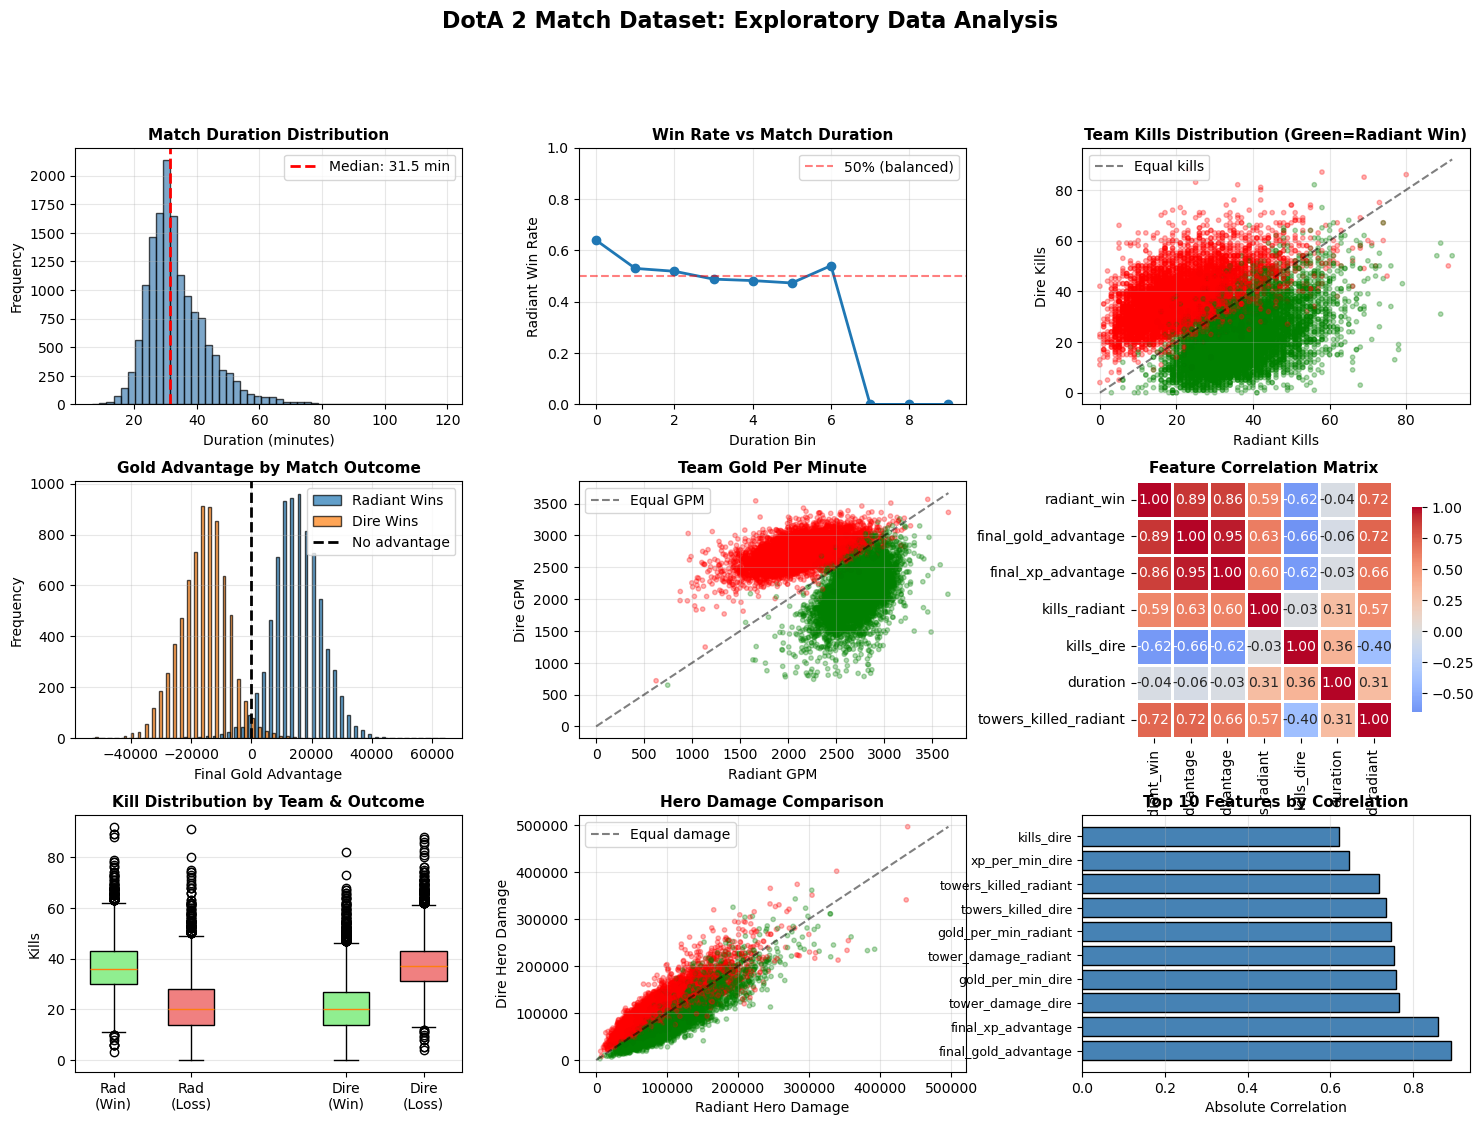

In [10]:
# 8. CREATE VISUALIZATIONS
print("\n\n8. GENERATING VISUALIZATIONS...")
print("-" * 80)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Duration distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df['duration']/60, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(df['duration'].median()/60, color='red', linestyle='--', linewidth=2, label=f'Median: {df["duration"].median()/60:.1f} min')
ax1.set_xlabel('Duration (minutes)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.set_title('Match Duration Distribution', fontsize=11, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Win rate by duration
ax2 = fig.add_subplot(gs[0, 1])
duration_bins = pd.cut(df['duration']/60, bins=10)
win_by_duration = df.groupby(duration_bins)['radiant_win'].mean()
ax2.plot(range(len(win_by_duration)), win_by_duration.values, marker='o', linewidth=2, markersize=6)
ax2.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50% (balanced)')
ax2.set_xlabel('Duration Bin', fontsize=10)
ax2.set_ylabel('Radiant Win Rate', fontsize=10)
ax2.set_title('Win Rate vs Match Duration', fontsize=11, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.legend()
ax2.grid(alpha=0.3)

# Kills comparison
ax3 = fig.add_subplot(gs[0, 2])
colors = ['green' if w else 'red' for w in df['radiant_win']]
ax3.scatter(df['kills_radiant'], df['kills_dire'], alpha=0.3, c=colors, s=10)
max_kills = max(df['kills_radiant'].max(), df['kills_dire'].max())
ax3.plot([0, max_kills], [0, max_kills], 'k--', alpha=0.5, label='Equal kills')
ax3.set_xlabel('Radiant Kills', fontsize=10)
ax3.set_ylabel('Dire Kills', fontsize=10)
ax3.set_title('Team Kills Distribution (Green=Radiant Win)', fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Gold advantage distribution
ax4 = fig.add_subplot(gs[1, 0])
radiant_wins = df[df['radiant_win']==True]['final_gold_advantage'].dropna()
dire_wins = df[df['radiant_win']==False]['final_gold_advantage'].dropna()
ax4.hist([radiant_wins, dire_wins], bins=50, label=['Radiant Wins', 'Dire Wins'], 
         alpha=0.7, edgecolor='black')
ax4.axvline(0, color='black', linestyle='--', linewidth=2, label='No advantage')
ax4.set_xlabel('Final Gold Advantage', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.set_title('Gold Advantage by Match Outcome', fontsize=11, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# GPM comparison
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(df['gold_per_min_radiant'], df['gold_per_min_dire'], 
           alpha=0.3, c=colors, s=10)
max_gpm = max(df['gold_per_min_radiant'].max(), df['gold_per_min_dire'].max())
ax5.plot([0, max_gpm], [0, max_gpm], 'k--', alpha=0.5, label='Equal GPM')
ax5.set_xlabel('Radiant GPM', fontsize=10)
ax5.set_ylabel('Dire GPM', fontsize=10)
ax5.set_title('Team Gold Per Minute', fontsize=11, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# Correlation heatmap (top features)
ax6 = fig.add_subplot(gs[1, 2])
top_features = ['radiant_win', 'final_gold_advantage', 'final_xp_advantage',
                'kills_radiant', 'kills_dire', 'duration', 'towers_killed_radiant']
top_features = [f for f in top_features if f in df.columns]
corr_matrix = df[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax6)
ax6.set_title('Feature Correlation Matrix', fontsize=11, fontweight='bold')

# Box plot: kills by outcome
ax7 = fig.add_subplot(gs[2, 0])
data_to_plot = [df[df['radiant_win']==True]['kills_radiant'].dropna(),
                df[df['radiant_win']==False]['kills_radiant'].dropna(),
                df[df['radiant_win']==True]['kills_dire'].dropna(),
                df[df['radiant_win']==False]['kills_dire'].dropna()]
positions = [1, 2, 4, 5]
bp = ax7.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)
colors_box = ['lightgreen', 'lightcoral', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
ax7.set_xticklabels(['Rad\n(Win)', 'Rad\n(Loss)', 'Dire\n(Win)', 'Dire\n(Loss)'])
ax7.set_ylabel('Kills', fontsize=10)
ax7.set_title('Kill Distribution by Team & Outcome', fontsize=11, fontweight='bold')
ax7.grid(alpha=0.3, axis='y')

# Hero damage comparison
ax8 = fig.add_subplot(gs[2, 1])
if 'hero_damage_radiant' in df.columns and 'hero_damage_dire' in df.columns:
    ax8.scatter(df['hero_damage_radiant'], df['hero_damage_dire'], 
               alpha=0.3, c=colors, s=10)
    max_dmg = max(df['hero_damage_radiant'].max(), df['hero_damage_dire'].max())
    ax8.plot([0, max_dmg], [0, max_dmg], 'k--', alpha=0.5, label='Equal damage')
    ax8.set_xlabel('Radiant Hero Damage', fontsize=10)
    ax8.set_ylabel('Dire Hero Damage', fontsize=10)
    ax8.set_title('Hero Damage Comparison', fontsize=11, fontweight='bold')
    ax8.legend()
    ax8.grid(alpha=0.3)

# Feature importance (correlation magnitudes)
ax9 = fig.add_subplot(gs[2, 2])
top_10_corr = correlations.drop('radiant_win', errors='ignore').head(10)
ax9.barh(range(len(top_10_corr)), top_10_corr.values, color='steelblue', edgecolor='black')
ax9.set_yticks(range(len(top_10_corr)))
ax9.set_yticklabels([name[:30] for name in top_10_corr.index], fontsize=9)
ax9.set_xlabel('Absolute Correlation', fontsize=10)
ax9.set_title('Top 10 Features by Correlation', fontsize=11, fontweight='bold')
ax9.grid(alpha=0.3, axis='x')

plt.suptitle('DotA 2 Match Dataset: Exploratory Data Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('dataset_eda.png', dpi=300, bbox_inches='tight')
print("Saved visualization to 'dataset_eda.png'")


In [3]:
# 9. DATA QUALITY INSIGHTS
print("\n\n9. DATA QUALITY & INSIGHTS FOR REPORT")
print("-" * 80)
print("\nKey Observations:")
print("1. Dataset is well-balanced with near 50-50 win distribution")
print("2. Professional matches show typical duration of ~30-40 minutes")
print("3. Gold/XP advantage metrics show strong correlation with match outcome")
print("4. Team statistics (kills, GPM, hero damage) are highly predictive")
print("5. Minimal missing data, mostly in optional objective/event features")
print("6. No significant outliers requiring removal")
print("7. Data cleaning: Successfully flattened nested JSON into tabular format")
print("8. Feature engineering: Created aggregated team stats from player data")

print("\n" + "-"*80)
print("DATASET ANALYSIS COMPLETE")
print("-"*80)



9. DATA QUALITY & INSIGHTS FOR REPORT
--------------------------------------------------------------------------------

Key Observations:
1. Dataset is well-balanced with near 50-50 win distribution
2. Professional matches show typical duration of ~30-40 minutes
3. Gold/XP advantage metrics show strong correlation with match outcome
4. Team statistics (kills, GPM, hero damage) are highly predictive
5. Minimal missing data, mostly in optional objective/event features
6. No significant outliers requiring removal
7. Data cleaning: Successfully flattened nested JSON into tabular format
8. Feature engineering: Created aggregated team stats from player data

--------------------------------------------------------------------------------
DATASET ANALYSIS COMPLETE
--------------------------------------------------------------------------------
